In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

### Data

In [2]:
df1 = pd.read_csv('../../DATA/HSC-unWISE-W01.csv')
df2 = pd.read_csv('../../DATA/HSC-unWISE-W02.csv')
df = pd.concat([df1,df2], axis = 'rows')
del df1,df2

In [13]:
with open('../../DATA/old_features.txt') as file:
    features = file.read().splitlines()
    # I was not using W1 as a feature here...
labels = 'member'

In [15]:
n_mem = df[df.member == 1].shape[0]
n_no = df[df.member == 0].shape[0]
n = df.shape[0]
print ('Members: {} ({:.2f}%)'.format(n_mem, n_mem/n*100))
print ('Members: {} ({:.2f}%)'.format(n_no, n_no/n*100))

del n,n_mem,n_no

Members: 40237 (16.58%)
Members: 202456 (83.42%)


### Model with weights

In [16]:
# wei =  compute_class_weight(class_weight = 'balanced', classes = np.unique(df[labels]), y = df[labels])
# weights = {}
# for w,l in zip(wei,np.unique(df[labels])):
#     weights[l] = w

# del wei
# print (weights)

{0: 0.5993722092701624, 1: 3.0157939210179685}


In [9]:
train, test = train_test_split(df, test_size = 0.3, stratify = df[labels])
val, test = train_test_split(test, test_size = 0.3, stratify = test[labels])

print ('Training: {} members, {} non members'.format(train[train.member == 1].shape[0], train[train.member == 0].shape[0]))
print ('Validation: {} members, {} non members'.format(val[val.member == 1].shape[0], val[val.member == 0].shape[0]))
print ('Testing: {} members, {} non members'.format(test[test.member == 1].shape[0], test[test.member == 0].shape[0]))

Training: 25573 members, 127248 non members
Validation: 7672 members, 38174 non members
Testing: 3288 members, 16361 non members


In [10]:
smote_train_feat, smote_train_lab = SMOTE(sampling_strategy= 'minority').fit_resample(train[features], train[labels])
print ('Training: {} members, {} non members'.format(smote_train_feat[smote_train_lab == 1].shape[0], smote_train_feat[smote_train_lab == 0].shape[0]))

Training: 127248 members, 127248 non members


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    # tf.keras.callbacks.CSVLogger(filename = 'csv_logger.csv'),
    # tf.keras.callbacks.ModelCheckpoint(filepath = 'checkpoint.csv', monitor = 'val_loss',  save_best_only = True),
    # tf.keras.callbacks.TensorBoard()
]

norm = tf.keras.layers.Normalization(input_shape=(len(features),))
norm.adapt(data = smote_train_feat) # data = train[features]

In [4]:
model = tf.keras.Sequential([
    # norm,
    tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GaussianDropout(0.2),
    tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GaussianDropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GaussianDropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.experimental.AdamW(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[]
)
# tf.keras.metrics.BinaryAccuracy(name = 'accuracy'), tf.keras.metrics.Precision(name = 'precision'), tf.keras.metrics.Recall(name = 'recall')

In [68]:
model.fit(
    x = smote_train_feat.values, 
    y = smote_train_lab.values,
    verbose = 2, 
    callbacks = callbacks,
    validation_data = (val[features].values, val[labels].values), 
    epochs = 80,
    batch_size = 4096
) #x = train[features].values, y = train[labels].values, class_weight = weights,

Epoch 1/80
63/63 - 7s - loss: 0.6360 - val_loss: 0.6260 - 7s/epoch - 117ms/step
Epoch 2/80
63/63 - 3s - loss: 0.6147 - val_loss: 0.6214 - 3s/epoch - 48ms/step
Epoch 3/80
63/63 - 3s - loss: 0.6089 - val_loss: 0.6183 - 3s/epoch - 48ms/step
Epoch 4/80
63/63 - 3s - loss: 0.6050 - val_loss: 0.6212 - 3s/epoch - 49ms/step
Epoch 5/80
63/63 - 3s - loss: 0.6015 - val_loss: 0.6178 - 3s/epoch - 48ms/step
Epoch 6/80
63/63 - 3s - loss: 0.5977 - val_loss: 0.6213 - 3s/epoch - 48ms/step
Epoch 7/80
63/63 - 3s - loss: 0.5959 - val_loss: 0.6185 - 3s/epoch - 50ms/step
Epoch 8/80
63/63 - 3s - loss: 0.5931 - val_loss: 0.6162 - 3s/epoch - 48ms/step
Epoch 9/80
63/63 - 3s - loss: 0.5905 - val_loss: 0.6154 - 3s/epoch - 49ms/step
Epoch 10/80
63/63 - 3s - loss: 0.5883 - val_loss: 0.6110 - 3s/epoch - 47ms/step
Epoch 11/80
63/63 - 3s - loss: 0.5864 - val_loss: 0.5958 - 3s/epoch - 48ms/step
Epoch 12/80
63/63 - 3s - loss: 0.5847 - val_loss: 0.6046 - 3s/epoch - 47ms/step
Epoch 13/80
63/63 - 3s - loss: 0.5832 - val_loss

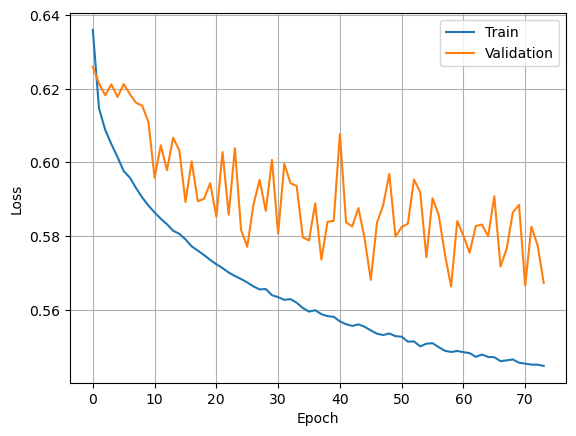

In [69]:
history = model.history.history
# plt.figure(figsize=(20,4))

# # plt.subplot(1, 4, 1)
# # plt.plot(history['accuracy'], label='Train')
# # plt.plot(history['val_accuracy'], label='Validation')
# # plt.ylabel('Accuracy')
# # plt.xlabel('Epoch')
# # plt.grid()
# # plt.legend()

# plt.subplot(1, 4, 2)
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

# plt.subplot(1, 4, 3)
# plt.plot(history['precision'], label='Train')
# plt.plot(history['val_precision'], label='Validation')
# plt.ylabel('Precision')
# plt.xlabel('Epoch')
# plt.grid()
# plt.legend()

# plt.subplot(1, 4, 4)
# plt.plot(history['recall'], label='Train')
# plt.plot(history['val_recall'], label='Validation')
# plt.ylabel('Recall')
# plt.xlabel('Epoch')
# plt.grid()
# plt.legend()

### Predictions

In [74]:
pred = model.predict(test[features], verbose = 0)
pred_classes = np.round(pred, decimals = 0)

test_loss = model.evaluate(test[features], test[labels], verbose=1)
print('Loss on test dataset: {:.4g}'.format(test_loss))

615/615 [==============================] - 2s 4ms/step - loss: 0.5703
Loss on test dataset: 0.5703


In [75]:
from sklearn.metrics import classification_report
print(classification_report(test[labels],pred_classes))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80     16361
           1       0.29      0.56      0.38      3288

    accuracy                           0.69     19649
   macro avg       0.59      0.64      0.59     19649
weighted avg       0.79      0.69      0.73     19649



Text(33.22222222222222, 0.5, 'True')

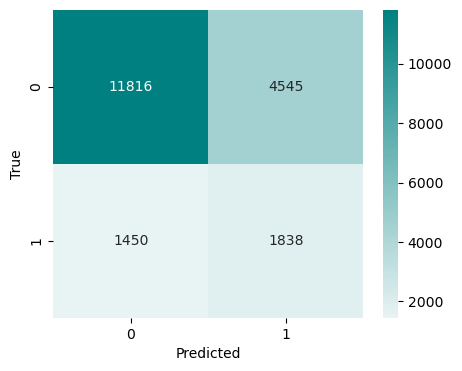

In [76]:
conf_m = confusion_matrix(test[labels], pred_classes)
df_conf_m = pd.DataFrame(conf_m, index=[0,1], columns=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(df_conf_m, cmap=sns.color_palette('light:teal', as_cmap=True), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

AUC: 0.7029427269108145


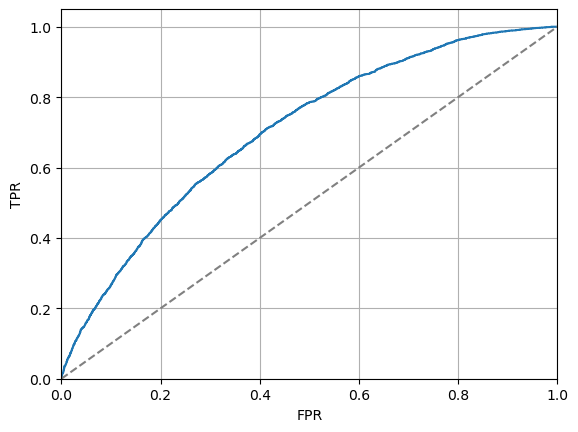

In [77]:
fpr, tpr, i = roc_curve(test[labels], pred, pos_label=1)

plt.plot(fpr, tpr)
print('AUC: {}'.format(auc(fpr, tpr)))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()